The code below models electronic response and noise by taking real data of dep and fep waveforms scaling their amplitudes to the normalized waveforms in the library of simulated data created in CreatingSignalLibrary.ipynb. A transfer function of one pole is applied to the waveforms to better model the electronic readout system and then finally randomized pink noise is added. 

In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

eng_peak = 'sep'
home_dir='/nas/longleaf/home/kbhimani/'

In [3]:
pickle_path_transformed_waveform = home_dir+f'training_data/{eng_peak}_cleaned.pickle'
def event_loader_data(address, elow=-99999, ehi=99999):
    wf_list = []
    count=0
    with (open(address, "rb")) as openfile:
        while True:
            try:
                wdict = pickle.load(openfile, encoding='latin1')
                wf = wdict["wf"]
                wf_list.append(wf)
            except EOFError:
                break
    return wf_list
data_ornl_fep = event_loader_data(home_dir+'CPU-Net/training_data/fep_cleaned.pickle')
data_ornl_dep = event_loader_data(home_dir+'CPU-Net/training_data/dep_cleaned.pickle')
data_ornl_sep = event_loader_data(home_dir+'CPU-Net/training_data/sep_cleaned.pickle')

Average sigma: 9.657876481251028
Average of max values (max_amp): 8356.869140625
Average sigma: 11.463820486437651
Average of max values (max_amp): 13356.828125
Average sigma: 12.9389104015546
Average of max values (max_amp): 10848.73828125


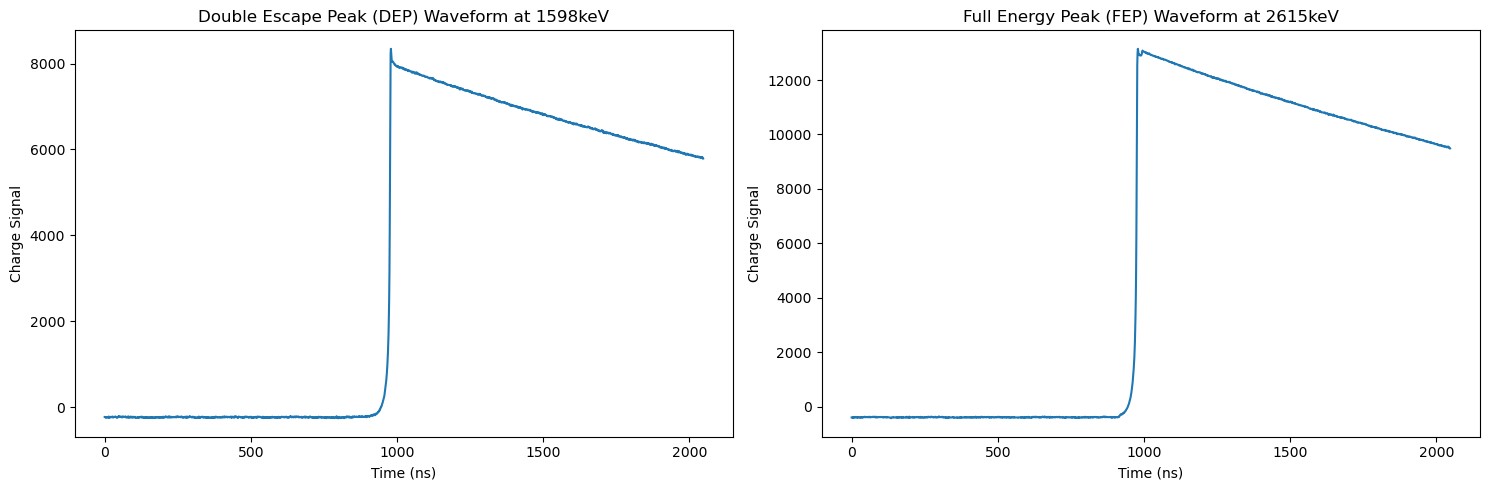

In [4]:
# Function to process waveforms
def process_waveforms(data, max_length):

    # Initialize lists to hold waveforms, sigma values, and max values
    waveform_list = []
    sigma_values = []
    max_values = []

    # Iterate over each stored array and append it to the list
    for waveform in data:
        waveform_list.append(waveform)


    # Loop through each waveform in the waveform list
    for waveform in waveform_list:
        y_values = waveform[:max_length].astype(float)
        y_values -= y_values.mean()

        # Calculate the maximum value of the waveform
        max_value = np.max(waveform)
        max_values.append(max_value)

        # Square and sum the result
        squared_sum = (y_values ** 2).sum()

        # Take the square root of the final answer
        sigma = np.sqrt(squared_sum / len(y_values))

        # Append sigma value to the list
        sigma_values.append(sigma)
    
    # Calculate the average sigma value
    average_sigma = np.mean(sigma_values)
    print(f"Average sigma: {average_sigma}")

    # Calculate the average of the maximum values
    max_amp = np.mean(max_values)
    print(f"Average of max values (max_amp): {max_amp}")

    return average_sigma, max_amp, waveform_list, sigma_values

# Process DEP waveforms
average_sigma_dep, max_dep_amp, dep_waveform_list, sigma_values_dep = process_waveforms(data_ornl_dep, 901)

# Process FEP waveforms
average_sigma_fep, max_fep_amp, fep_waveform_list, sigma_values_fep = process_waveforms(data_ornl_fep, 901)

average_sigma_sep, max_sep_amp, sep_waveform_list, sigma_values_sep = process_waveforms(data_ornl_sep, 901)


# Plot an example DEP and FEP waveform side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot DEP waveform
dep_waveform = dep_waveform_list[0]
axs[0].plot(dep_waveform)
axs[0].set_title('Double Escape Peak (DEP) Waveform at 1598keV')
axs[0].set_xlabel('Time (ns)')
axs[0].set_ylabel('Charge Signal')

# Plot FEP waveform
fep_waveform = fep_waveform_list[0]
axs[1].plot(fep_waveform)
axs[1].set_title('Full Energy Peak (FEP) Waveform at 2615keV')
axs[1].set_xlabel('Time (ns)')
axs[1].set_ylabel('Charge Signal')

plt.tight_layout()
plt.show()

In [6]:
def event_loader_sim(address, elow=-99999, ehi=99999):
    wf_list = []
    count=0
    with (open(address, "rb")) as openfile:
        while True:
            try:
                wdict = pickle.load(openfile, encoding='latin1')
                wf = wdict["wf"]
                wf_list.append(wf)
            except EOFError:
                break
    return wf_list
sim = event_loader_sim(home_dir + f"CPU-Net/training_data/{eng_peak}_wf_sim.pickle")
# Create a DataFrame with r, phi, z, and data_column
data = {
    'r': [0.0] * len(sim),
    'phi': [0.0] * len(sim),
    'z': [0.0] * len(sim),  # Example z values
    'data_column': sim
}

sim_df = pd.DataFrame(data)

In [7]:
# Define the number of zero-padding data points to add at the beginning
num_padding_points = 500  # Adjust this value as needed

# Function to normalize data
def normalize_data(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (data - min_val) / (max_val - min_val)

# Load the DataFrame
# df = pd.read_pickle('output_dataframe.pkl')
df=sim_df
print(df)
# Pad the waveforms first
def pad_waveforms(df, num_padding_points):
    padded_list = []
    for waveform in df['data_column']:
        # Normalize the waveform
        normalized_waveform = normalize_data(waveform)
        # Pad the waveform with zeros at the beginning
        padded_waveform = np.pad(normalized_waveform, (num_padding_points, 0), mode='constant')
        padded_list.append(padded_waveform)
    return pd.Series(padded_list)

df['data_column'] = pad_waveforms(df, num_padding_points)

         r  phi    z                                        data_column
0      0.0  0.0  0.0  [0.11473833, 0.252136, 0.37277293, 0.47798476,...
1      0.0  0.0  0.0  [0.0022478835, 0.005363204, 0.009116233, 0.013...
2      0.0  0.0  0.0  [0.002111819, 0.0050789365, 0.008716716, 0.012...
3      0.0  0.0  0.0  [0.005342869, 0.012753581, 0.020828294, 0.0274...
4      0.0  0.0  0.0  [0.36117145, 0.92437613, 1.5638114, 2.2131946,...
...    ...  ...  ...                                                ...
12696  0.0  0.0  0.0  [0.046694584, 0.11380026, 0.19190641, 0.270465...
12697  0.0  0.0  0.0  [0.07655937, 0.18774721, 0.32176816, 0.4661443...
12698  0.0  0.0  0.0  [1.1510595, 3.5256813, 5.9681497, 8.478882, 11...
12699  0.0  0.0  0.0  [0.021612093, 0.05113287, 0.086059615, 0.12175...
12700  0.0  0.0  0.0  [1.1622986, 3.0398014, 5.1398683, 7.277602, 9....

[12701 rows x 4 columns]


0it [00:00, ?it/s]


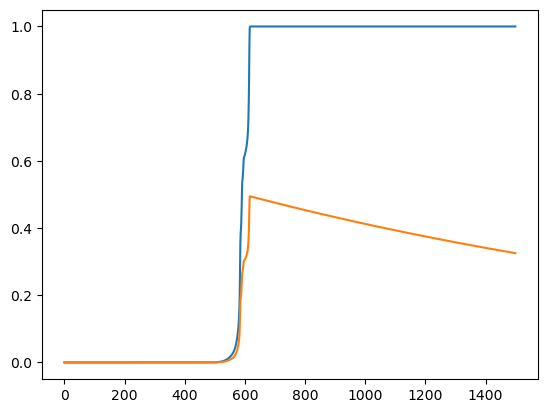

In [9]:
# Define transfer functions
tau = 33700 / 16
num1 = [.5, 0]
den1 = [1, 1 / tau]
sys1 = signal.TransferFunction(num1, den1)

num2 = [1 - .983, 0]
den2 = [1, 1 / 122]
sys2 = signal.TransferFunction(num2, den2)

def apply_transfer_function(waveform, sys):
    _, y_response, _ = signal.lsim(sys, waveform, np.arange(len(waveform)))
    return y_response

def apply_double_pole_zero(waveform):
    # Apply the first transfer function
    y_response1 = apply_transfer_function(waveform, sys1)
    # Apply the second transfer function
    y_response2 = apply_transfer_function(y_response1, sys2)
    return y_response2

# Initialize lists to hold transformed waveforms
dep_transformed_list = []
fep_transformed_list = []
sep_transformed_list = []
# Scale and apply transfer functions
for i, waveform in tqdm(enumerate(df['data_column'])):
    # Normalize the waveform
    plt.plot(waveform)
    transformed = apply_transfer_function(waveform, sys1)
    plt.plot(transformed)
    normalized_waveform = normalize_data(transformed)
    # Scale by dep_scaled_waveform and fep_scaled_waveform
    dep_transformed = normalized_waveform * max_dep_amp
    fep_transformed = normalized_waveform * max_fep_amp
    sep_transformed = normalized_waveform * max_sep_amp
    # Append transformed waveforms to lists
    dep_transformed_list.append(dep_transformed)
    fep_transformed_list.append(fep_transformed)
    sep_transformed_list.append(sep_transformed)
    break

# Convert lists to Series objects
dep_series = pd.Series(dep_transformed_list)
fep_series = pd.Series(fep_transformed_list)
sep_series = pd.Series(sep_transformed_list)

# Assign Series to new columns in the DataFrame
df['dep'] = dep_series
df['fep'] = fep_series
df['sep'] = sep_series

# Choose the index of the waveform to plot (e.g., 0 for the first waveform)
waveform_index = 3

# Retrieve the padded waveform, dep waveform, and fep waveform for the chosen index
padded_waveform = df['data_column'][waveform_index]
dep_waveform = df['dep'][waveform_index]
fep_waveform = df['fep'][waveform_index]

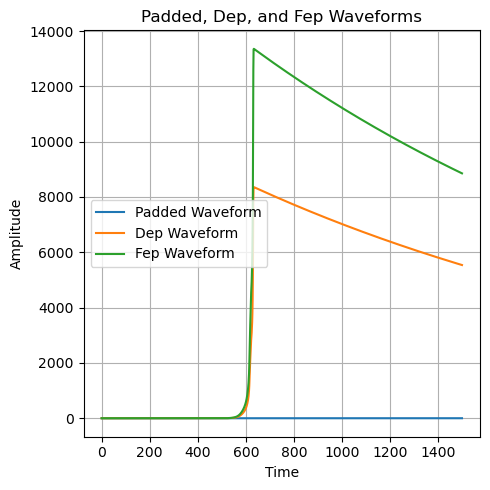

In [12]:
# Plot an example of the padded and transformed DEP and FEP waveform side by side
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# Choose the index of the waveform to plot (e.g., 0 for the first waveform)
waveform_index = 3

# Retrieve the padded waveform, dep waveform, and fep waveform for the chosen index
padded_waveform = df['data_column'][waveform_index]
dep_waveform = df['dep'][waveform_index]
fep_waveform = df['fep'][waveform_index]

# Create a time array for plotting
time = np.arange(len(padded_waveform))

# Plot all three waveforms on the same plot
ax.plot(time, padded_waveform, label='Padded Waveform')
ax.plot(time, dep_waveform, label='Dep Waveform')
ax.plot(time, fep_waveform, label='Fep Waveform')
ax.set_title('Padded, Dep, and Fep Waveforms')
ax.set_xlabel('Time')
ax.set_ylabel('Amplitude')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

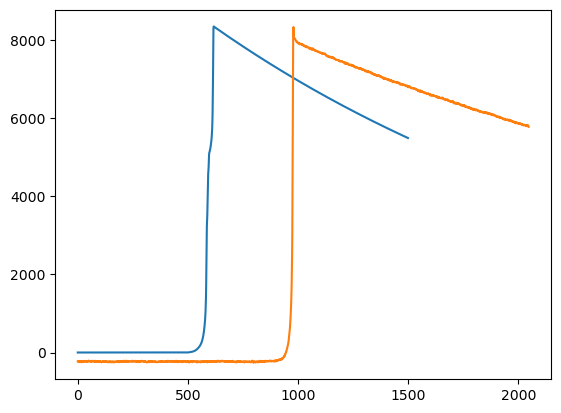

In [23]:
plt.plot(df["dep"][0])
plt.plot(dep_waveform_list[0])

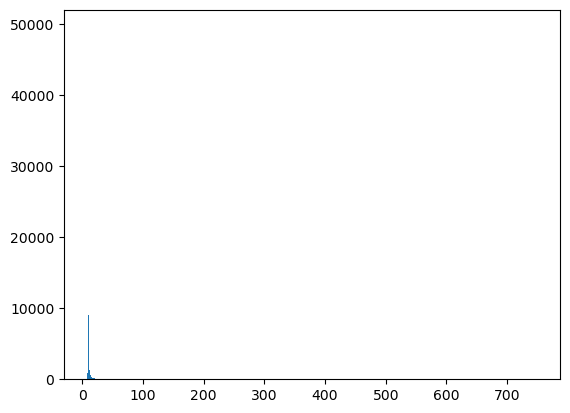

In [11]:
#plt.hist(sigma_values, bins=(100), range=(0,2))
x=plt.hist(sigma_values_fep, bins=(1000))
#plt.yscale("log")
#print(sigma_values)

In [24]:
print(df)

         r  phi    z                                        data_column  \
0      0.0  0.0  0.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1      0.0  0.0  0.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2      0.0  0.0  0.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3      0.0  0.0  0.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4      0.0  0.0  0.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
...    ...  ...  ...                                                ...   
12696  0.0  0.0  0.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
12697  0.0  0.0  0.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
12698  0.0  0.0  0.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
12699  0.0  0.0  0.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
12700  0.0  0.0  0.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                     dep  \
0      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

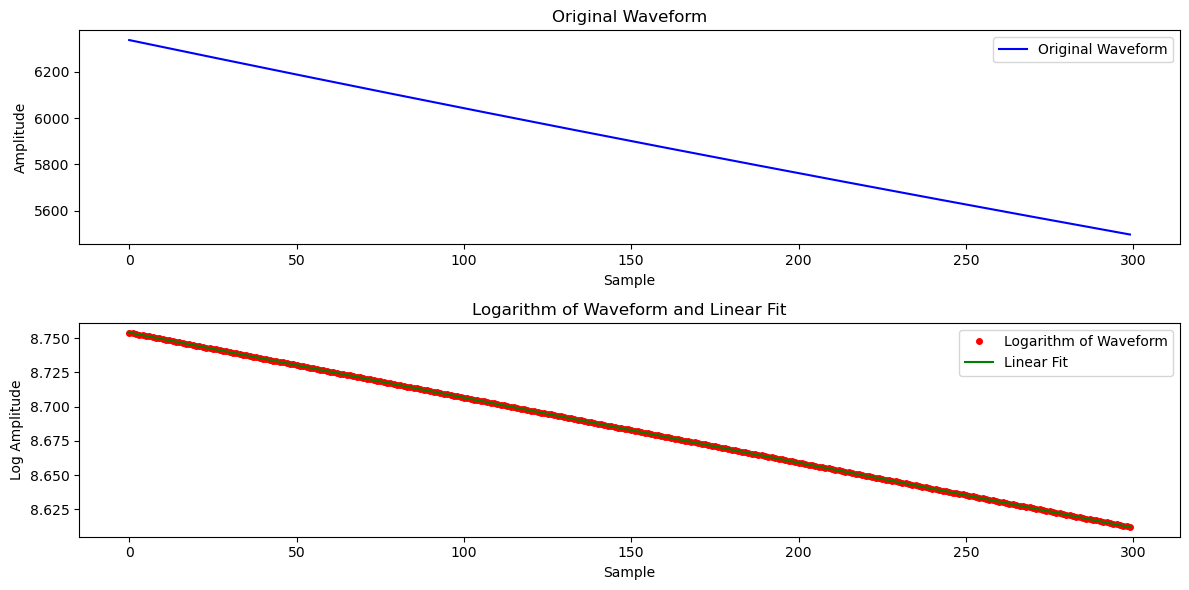

-0.0004747774541552327

In [60]:
from scipy.optimize import curve_fit
def linear(x, a, b):
    """Linear function ax + b"""
    return a * x + b
def get_tail_slope(wf, plot_sample=False):
    sample = 300
    fit_coefficients = []
    if len(wf) < sample:
        return 0  # Skip waveforms with fewer than 300 samples
    x_data = np.arange(sample)
    y_data = np.log(np.clip(wf[-sample:], 1e-10, None))  # Log of last 300 samples, avoiding log(0)
    try:
        popt, pcov = curve_fit(linear, x_data, y_data, maxfev=100000)
        if plot_sample:
            plot_slope_calc(x_data, y_data, popt, wf[-sample:])
    except Exception as e:
        print(f"Failed to fit waveform due to {e}. Appending NaN values.")
        return 0
    return popt[0]
def plot_slope_calc(x_data, y_data, popt, original_wf):
    plt.figure(figsize=(12, 6))

    # Plotting the original waveform
    plt.subplot(2, 1, 1)
    plt.plot(original_wf, 'b-', label='Original Waveform')
    plt.title('Original Waveform')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend()

    # Plotting the logarithm of the waveform and the linear fit
    plt.subplot(2, 1, 2)
    plt.plot(x_data, y_data, 'ro', label='Logarithm of Waveform', markersize=4)
    plt.plot(x_data, linear(x_data, *popt), 'g-', label='Linear Fit')
    plt.title('Logarithm of Waveform and Linear Fit')
    plt.xlabel('Sample')
    plt.ylabel('Log Amplitude')
    plt.legend()
    plt.tight_layout()
    plt.show()
get_tail_slope(df['dep'][0], plot_sample=True)

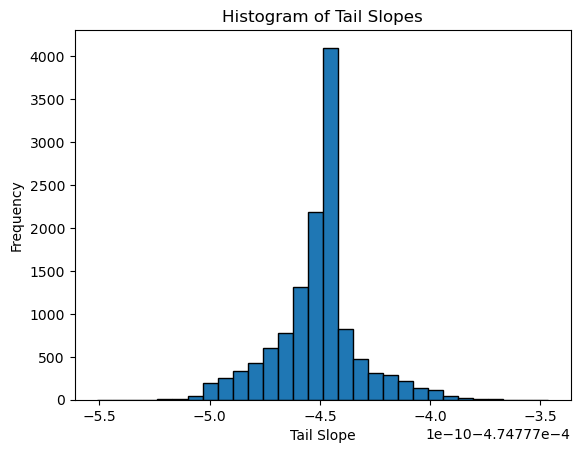

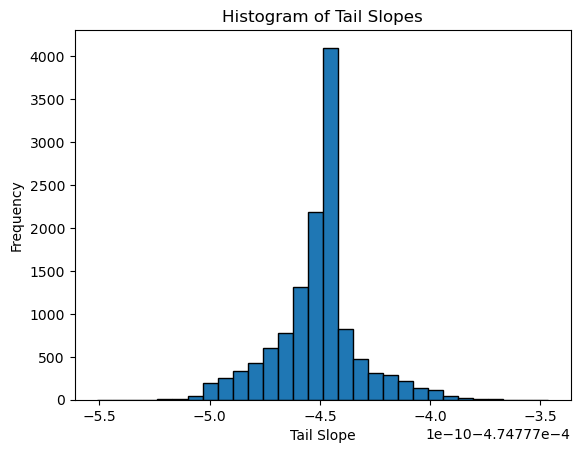

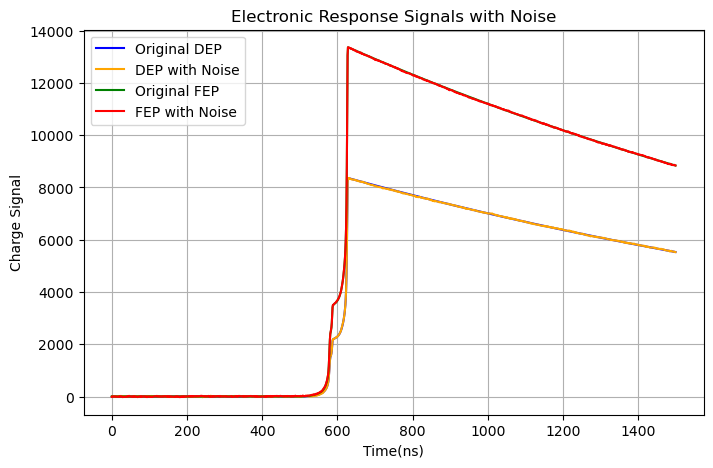

In [29]:
def noise_psd(N, psd=lambda f: 1):
    X_white = np.fft.rfft(np.random.randn(N))
    S = psd(np.fft.rfftfreq(N))
    # Normalize S
    S = S / np.sqrt(np.mean(S**2))
    X_shaped = X_white * S
    return np.fft.irfft(X_shaped, n=N)

def PSDGenerator(f):
    return lambda N, scale: noise_psd(N, f) * scale

@PSDGenerator
def pink_noise(f):
    return 1 / np.where(f == 0, float('inf'), np.sqrt(f))

# Define noise scale
dep_noise_scale = average_sigma_dep
fep_noise_scale = average_sigma_fep
sep_noise_scale = average_sigma_sep

# Initialize lists to store generated noise signals
dep_with_noise_list = []
fep_with_noise_list = []
sep_with_noise_list = []

# Iterate through each waveform and add pink noise
for i in range(len(df)):
    # Generate pink noise signals for dep and fep waveforms
    dep_pink_noise_signal_transformed = pink_noise(len(df['dep'][i]), dep_noise_scale)
    fep_pink_noise_signal_transformed = pink_noise(len(df['fep'][i]), fep_noise_scale)
    sep_pink_noise_signal_transformed = pink_noise(len(df['fep'][i]), sep_noise_scale)

    # Add pink noise to dep and fep transformed waveforms
    dep_transformed_waveform_with_noise = df['dep'][i] + dep_pink_noise_signal_transformed
    fep_transformed_waveform_with_noise = df['fep'][i] + fep_pink_noise_signal_transformed
    sep_transformed_waveform_with_noise = df['sep'][i] + sep_pink_noise_signal_transformed

    # Append generated noise signals to lists
    dep_with_noise_list.append(dep_transformed_waveform_with_noise)
    fep_with_noise_list.append(fep_transformed_waveform_with_noise)
    sep_with_noise_list.append(sep_transformed_waveform_with_noise)
# Convert lists to DataFrame columns
df['dep_with_noise'] = dep_with_noise_list
df['fep_with_noise'] = fep_with_noise_list
df['sep_with_noise'] = sep_with_noise_list
# Select a row index to plot (you can choose any index within the range of your DataFrame)
row_index = 5

# Extract original and noisy waveforms
original_dep = df['dep'][row_index]
noisy_dep = df['dep_with_noise'][row_index]
original_fep = df['fep'][row_index]
noisy_fep = df['fep_with_noise'][row_index]

# Create time array
time_dep = np.arange(len(original_dep))
time_fep = np.arange(len(original_fep))

# Plot both waveforms (DEP and FEP) with and without noise
plt.figure(figsize=(8, 5))

plt.plot(time_dep, original_dep, label='Original DEP', color='blue')
plt.plot(time_dep, noisy_dep, label='DEP with Noise', color='orange')
plt.plot(time_fep, original_fep, label='Original FEP', color='green')
plt.plot(time_fep, noisy_fep, label='FEP with Noise', color='red')

plt.title('Electronic Response Signals with Noise')
plt.xlabel('Time(ns)')
plt.ylabel('Charge Signal')
plt.legend()
plt.grid(True)
plt.show()


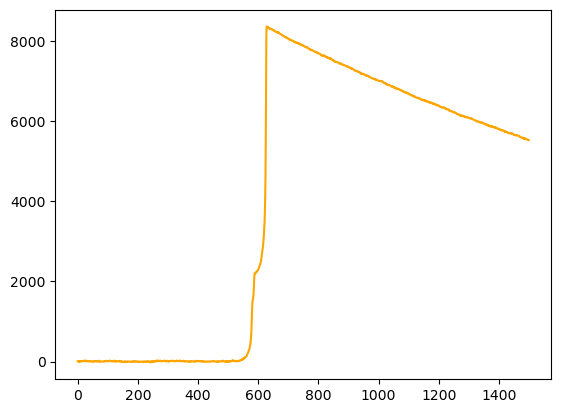

In [30]:
plt.plot(time_dep, noisy_dep, label='DEP with Noise', color='orange')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


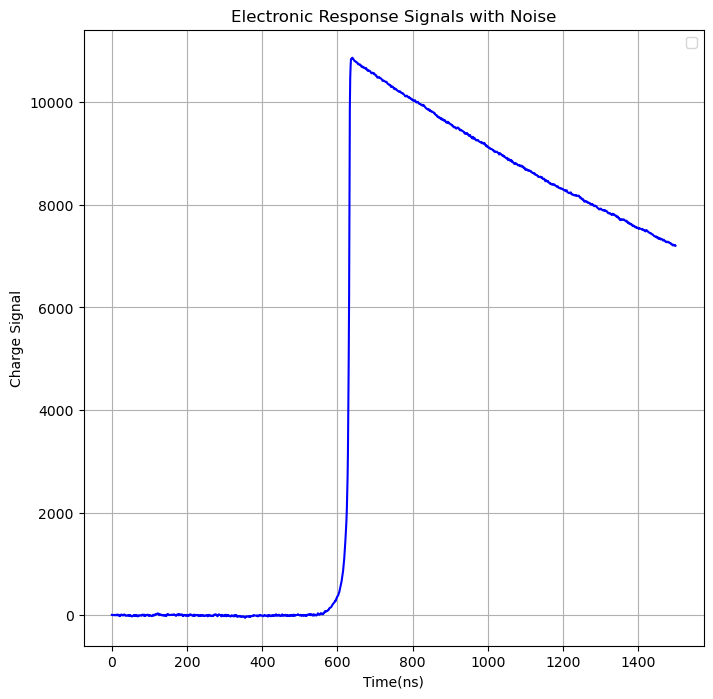

In [31]:
# Plot both waveforms (DEP and FEP) with and without noise
plt.figure(figsize=(8, 8))
plt.plot(time_dep,df["sep_with_noise"][2], color='blue')
plt.title('Electronic Response Signals with Noise')
plt.xlabel('Time(ns)')
plt.ylabel('Charge Signal')
plt.legend()
plt.grid(True)
plt.show()


In [32]:
print(df)

         r  phi    z                                        data_column  \
0      0.0  0.0  0.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1      0.0  0.0  0.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2      0.0  0.0  0.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3      0.0  0.0  0.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4      0.0  0.0  0.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
...    ...  ...  ...                                                ...   
12696  0.0  0.0  0.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
12697  0.0  0.0  0.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
12698  0.0  0.0  0.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
12699  0.0  0.0  0.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
12700  0.0  0.0  0.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                     dep  \
0      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [33]:
data = df
pickle_path_data_column = home_dir+f'/training_data/{eng_peak}_valid_sim.pkl'
pickle_path_transformed_waveform = home_dir+f'/training_data/{eng_peak}_valid_transfromed.pkl'
with open(pickle_path_data_column, 'wb') as f_data, open(pickle_path_transformed_waveform, 'wb') as f_transformed:
    for index, row in tqdm(data.iterrows(), total=data.shape[0], desc="Processing Data"):
        event_id = index  
        energy = 0
        
        # Process 'data_column'
        waveform_data = np.array(data["data_column"][index])
        if waveform_data is not None:
            event_dict_data = {
                "tp0": 0,
                "wf": waveform_data.astype(np.float32),
                "event": event_id,
                "energy": energy,
            }
            pickle.dump(event_dict_data, f_data, protocol=pickle.HIGHEST_PROTOCOL)
        
        # Process 'transformed_waveform'
        waveform_transformed = np.array(data[f"{eng_peak}_with_noise"][index])
        if waveform_transformed is not None:
            event_dict_transformed = {
                "tp0": 0,
                "wf": waveform_transformed.astype(np.float32),
                "event": event_id,
                "energy": energy,
            }
            pickle.dump(event_dict_transformed, f_transformed, protocol=pickle.HIGHEST_PROTOCOL)
    print("Completed saving waveforms.")

Processing Data: 100%|██████████| 12701/12701 [00:01<00:00, 11077.39it/s]

Completed saving waveforms.


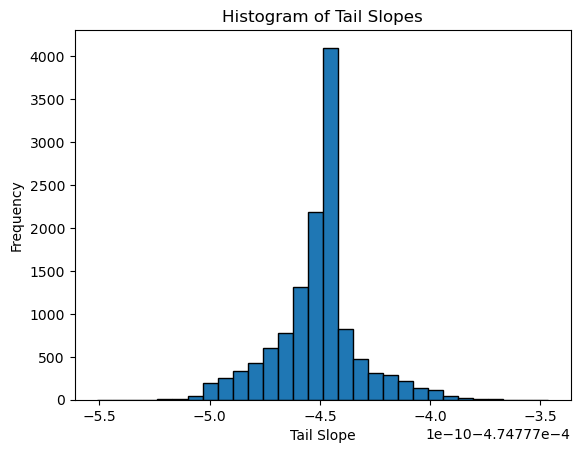

In [65]:
# Calculate the tail slopes
tail_slopes = [get_tail_slope(wf) for wf in df['dep']]
# Plot the histogram
plt.hist(tail_slopes, bins=30, edgecolor='black')
plt.xlabel('Tail Slope')
plt.ylabel('Frequency')
plt.title('Histogram of Tail Slopes')
plt.show()

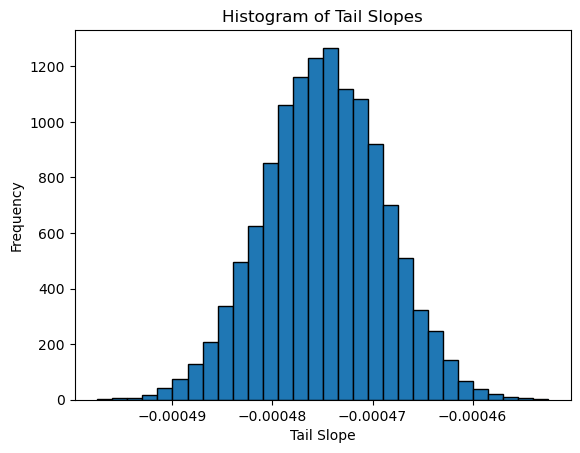

In [66]:
# Calculate the tail slopes
tail_slopes = [get_tail_slope(wf) for wf in df['dep_with_noise']]
# Plot the histogram
plt.hist(tail_slopes, bins=30, edgecolor='black')
plt.xlabel('Tail Slope')
plt.ylabel('Frequency')
plt.title('Histogram of Tail Slopes')
plt.show()